In [1]:
import pandas as pd
import sys
import csv
import os
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
default_color = "#2171b5"
csv.field_size_limit(sys.maxsize)

os.chdir('../Data/Seattle/')

# Data Cleaning 

In [202]:
def clean():
    
    # Load all datasets
    df_review = pd.read_csv('seattle_reviews.csv', sep=None,engine='python')
    df_insp1 = pd.read_csv('seattle_instances_mergerd.csv', sep=None,engine='python')
    df_insp2 = pd.read_csv('Food_Establishment_Inspection_Data.csv')
    df_insp2 = df_insp2.rename(columns={'Inspection_Serial_Num': 'inspection_id'})
    df_insp = df_insp1.merge(df_insp2,on="inspection_id")
    print(len(df_insp.inspection_id.unique()))
    
    # Convert to datetime object
    df_insp.inspection_period_start_date = pd.to_datetime(df_insp.inspection_period_start_date)
    df_insp.inspection_period_end_date = pd.to_datetime(df_insp.inspection_period_end_date)
    df_review.review_date = pd.to_datetime(df_review.review_date)
    df_insp['inspection_year'] = df_insp["inspection_period_end_date"].dt.year
    df_insp['inspection_month'] = df_insp["inspection_period_end_date"].dt.month
    
    # Remove inpection_score = -1 outlier
    df_insp = df_insp[df_insp.inspection_penalty_score >= 0]
    
    # Merge inspection data with review
    df_merge = pd.merge(df_insp, df_review, on="restaurant_id", how="left")
    
    # Only care about reviews that is commented within inspection rage
    review_lower = (df_merge.review_date >= df_merge.inspection_period_start_date)
    review_upper = (df_merge.review_date <= df_merge.inspection_period_end_date)
    df_merge = df_merge[review_lower & review_upper]
    
    # Convert violation type to categorical code 
    df_merge['Violation Type'] = pd.Categorical(df_merge['Violation Type'])
    df_merge['violation_code'] = df_merge['Violation Type'].cat.codes
    
    # Groupby inspection to extract the most severe violation type
    group = ['inspection_id', 'restaurant_id', 'inspection_period_start_date',
       'inspection_period_end_date', 'inspection_penalty_score',
       'inspection_average_prev_penalty_scores',
       'inspection_prev_penalty_score', 'cuisines', 'zip_code', 'review_count',
       'non_positive_review_count', 'average_review_rating', 'review_contents',
       'Program Identifier', 'Inspection Date', 'Description', 'Zip Code',
       'Longitude', 'Latitude', 'Inspection Business Name', 'Inspection Type',
       'Inspection Score', 'Inspection Result', 'Inspection Closed Business',
       'inspection_year','inspection_month', 'review_id', 'review_date', 'rating', 'content']
    
    df_indivd = df_merge.groupby(group, as_index=False).agg(
        {'Violation_Record_ID':'max','violation_code':'max','Violation Points':'mean','Violation Description':'max'})
    df_agg = df_indivd[df_indivd.columns.drop(
        ['review_id', 'review_date', 'rating', 'content'])].drop_duplicates(keep='first')
    print(df_indivd.shape)
    print(df_agg.shape)
    return {'individual':df_indivd,'aggregated':df_agg}

In [203]:
df = clean()

7705
(107553, 34)
(7703, 30)


In [204]:
df['individual'].to_csv("individual_review_inspection_merged_cleaned.csv")
df['aggregated'].to_csv("aggregated_review_inspection_merged_cleaned.csv")

# Data Exploration - Inspection

In [205]:
df = pd.read_csv('individual_review_inspection_merged_cleaned.csv', sep=None,engine='python')
df_agg = pd.read_csv('aggregated_review_inspection_merged_cleaned.csv', sep=None,engine='python')

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107553 entries, 0 to 107552
Data columns (total 35 columns):
Unnamed: 0                                107553 non-null int64
inspection_id                             107553 non-null object
restaurant_id                             107553 non-null object
inspection_period_start_date              107553 non-null object
inspection_period_end_date                107553 non-null object
inspection_penalty_score                  107553 non-null int64
inspection_average_prev_penalty_scores    107553 non-null float64
inspection_prev_penalty_score             107553 non-null int64
cuisines                                  107553 non-null object
zip_code                                  107553 non-null int64
review_count                              107553 non-null int64
non_positive_review_count                 107553 non-null int64
average_review_rating                     107553 non-null float64
review_contents                           107553

In [207]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 31 columns):
Unnamed: 0                                7703 non-null int64
inspection_id                             7703 non-null object
restaurant_id                             7703 non-null object
inspection_period_start_date              7703 non-null object
inspection_period_end_date                7703 non-null object
inspection_penalty_score                  7703 non-null int64
inspection_average_prev_penalty_scores    7703 non-null float64
inspection_prev_penalty_score             7703 non-null int64
cuisines                                  7703 non-null object
zip_code                                  7703 non-null int64
review_count                              7703 non-null int64
non_positive_review_count                 7703 non-null int64
average_review_rating                     7703 non-null float64
review_contents                           7703 non-null object
Program Identif

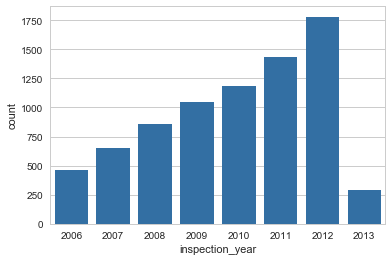

In [167]:
sns.countplot(x=df_agg.inspection_year, data=df_agg, color=default_color)

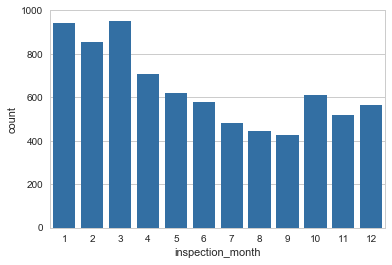

In [130]:
sns.countplot(x=df_agg.inspection_month, data=df_agg, color=default_color)

In [146]:
df.columns

Index(['Unnamed: 0', 'inspection_id', 'restaurant_id',
       'inspection_period_start_date', 'inspection_period_end_date',
       'inspection_penalty_score', 'inspection_average_prev_penalty_scores',
       'inspection_prev_penalty_score', 'cuisines', 'zip_code', 'review_count',
       'non_positive_review_count', 'average_review_rating', 'review_contents',
       'Program Identifier', 'Inspection Date', 'Description', 'Zip Code',
       'Longitude', 'Latitude', 'Inspection Business Name', 'Inspection Type',
       'Inspection Score', 'Inspection Result', 'Inspection Closed Business',
       'inspection_year', 'inspection_month', 'review_id', 'review_date',
       'rating', 'content', 'Violation_Record_ID', 'violation_code',
       'Violation Points'],
      dtype='object')

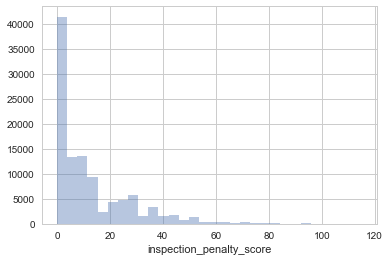

In [151]:
sns.distplot(df.inspection_penalty_score, bins=30, kde=False, rug=False)

In [36]:
rest_count = df.restaurant_id.value_counts()

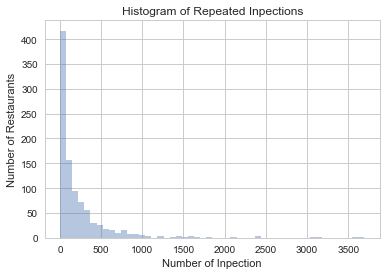

In [37]:
# Repeated inspection
g = sns.distplot(rest_count, kde=False)
g.set(xlabel='Number of Inpection', ylabel='Number of Restaurants')
plt.title("Histogram of Repeated Inpections")
plt.show(g)

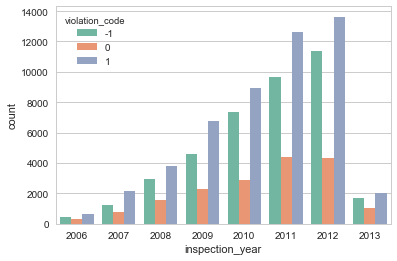

In [154]:
sns.countplot(x="inspection_year", hue="violation_code", data=df, palette="Set2")

In [195]:
df[["average_review_rating","inspection_penalty_score"]].corr(method= 'spearman')

,average_review_rating,inspection_penalty_score
average_review_rating,1.000000,-0.061324
inspection_penalty_score,-0.061324,1.000000


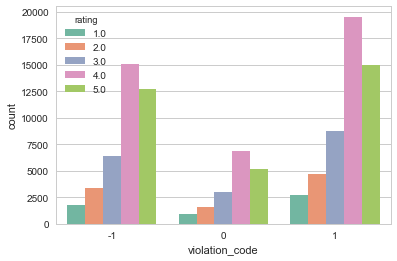

In [197]:
sns.countplot(x="violation_code", hue="rating", data=df, palette="Set2")

In [218]:
print(df[(df['violation_code'] > 0) & (df['rating'] < 4)].shape)
print(df[(df['violation_code'] <=0) & (df['rating'] > 3)].shape)

(16106, 35)
(39799, 35)


## Review rating is not informative!

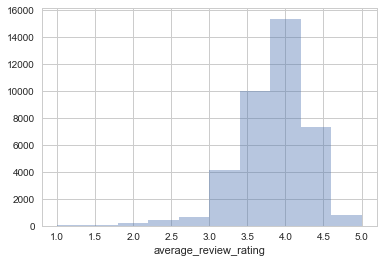

In [39]:
# No code violation restaurant
sns.distplot(df[df["inspection_penalty_score"] == 0]["average_review_rating"], bins = 10,kde=False)

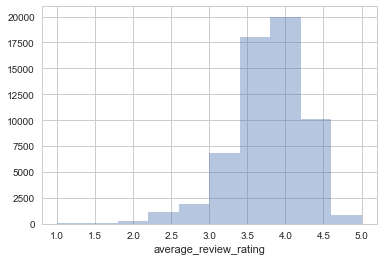

In [40]:
sns.distplot(df[df["inspection_penalty_score"] > 30]["average_review_rating"], bins = 10,kde=False)

In [41]:
corr = []
thresholds = [0,10,20,30,40,50,60,70]
for i in thresholds:
    corr_table = df[df["inspection_penalty_score"] > i][["average_review_rating","inspection_penalty_score"]].corr(method= 'spearman')
    corr.append(corr_table.iloc[0][1])

In [42]:
pprint(corr)

[0.018194108354997206,
 0.036412298873259467,
 0.0033654016126617643,
 0.069334472859118146,
 0.10536948454317527,
 0.16457754843476952,
 0.058505176722379412,
 -0.10905734436430707]


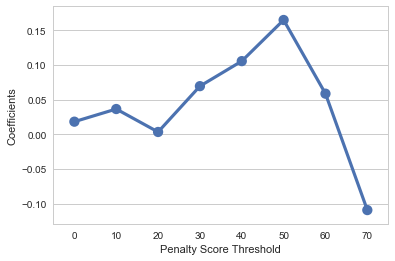

In [43]:
g = sns.pointplot(thresholds, corr)
g.set(xlabel='Penalty Score Threshold', ylabel='Coefficients')
g

**Weird that penalty score positively correlated with average rating**

## Review Count (Positive corr)

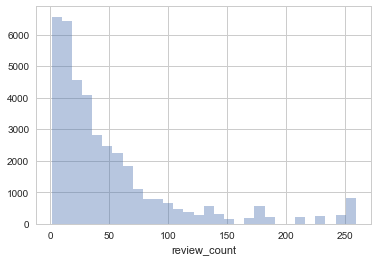

In [44]:
sns.distplot(df[df["inspection_penalty_score"] == 0]["review_count"], bins = 30,kde=False)

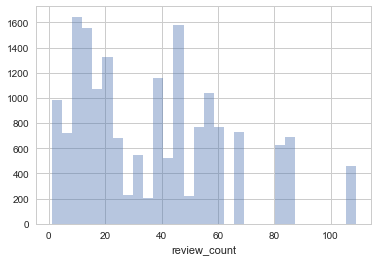

In [45]:
sns.distplot(df[df["inspection_penalty_score"] > 50]["review_count"], bins = 30,kde=False)

In [46]:
corr = []
thresholds = [0,10,20,30,40,50,60]
for i in thresholds:
    corr_table = df[df["inspection_penalty_score"] > i][["review_count","inspection_penalty_score"]].corr(method= 'spearman')
    corr.append(corr_table.iloc[0][1])

In [47]:
corr

[0.066292379525356604,
 0.10744873761686172,
 0.069390337362934235,
 0.035324682719477328,
 0.078138810675862203,
 0.2063217957816415,
 -0.12177844185005257]

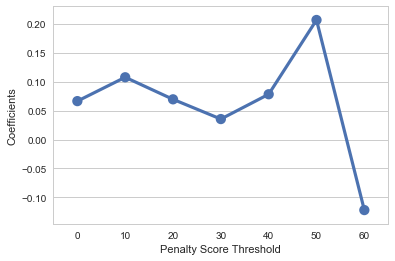

In [48]:
g = sns.pointplot(thresholds, corr)
g.set(xlabel='Penalty Score Threshold', ylabel='Coefficients')
g

## Geo Distribution

In [49]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
map = gpd.read_file("Seattle/zip-codes.geojson")

In [ ]:
map['GEOID10'] = pd.to_numeric(map['GEOID10'])

In [ ]:
vc = df[df["inspection_penalty_score"] > 0]["zip_code"].value_counts()
counts = pd.DataFrame({'GEOID10':vc.index, 'count':vc.values})

In [ ]:
heatmap = pd.merge(map, counts, on = "GEOID10",how="left")

In [ ]:
heatmap.plot(column='count',cmap='BuPu')